# Deploy a Trained Model

In this notebook, we walk through the process of deploying a trained model to a SageMaker endpoint. If you recently ran [the notebook for training](get_started_mnist_deploy.ipynb) with %store% magic, the `model_data` can be restored. Otherwise, we retrieve the 
model artifact from a public S3 bucket.

In [13]:
# setups

import os
import json


import boto3
import sagemaker
from sagemaker.mxnet import MXNetModel
from sagemaker import get_execution_role, Session

# Get global config

sess = Session()
role = get_execution_role()

#%store -r mx_mnist_model_data

try: 
    mx_mnist_model_data
except NameError:
    import json
    # copy a pretrained model from a public public to your default bucket
    s3 = boto3.client('s3')
    bucket = 'sagemaker-sample-files'
    key = 'datasets/image/MNIST/model/mxnet-training-2020-11-21-01-38-01-009/model.tar.gz'
    s3.download_file(bucket, key, 'model.tar.gz')
    
    # upload to default bucket
    mx_mnist_model_data = sess.upload_data(
        path='model.tar.gz',bucket=sess.default_bucket(),key_prefix='model/mxnet')
    
    # delete local copy
    os.remove('model.tar.gz')
    
    

In [1]:
# always download from remote
import os
import json


import boto3
import sagemaker
from sagemaker.mxnet import MXNetModel
from sagemaker import get_execution_role, Session


import json

# Get global config


role = get_execution_role()
sess = Session()

# copy a pretrained model from a public public to your default bucket
s3 = boto3.client('s3')
bucket = 'sagemaker-sample-files'
key = 'datasets/image/MNIST/model/mxnet-training-2020-11-21-01-38-01-009/model.tar.gz'
s3.download_file(bucket, key, 'model.tar.gz')

# upload to default bucket
mx_mnist_model_data = sess.upload_data(
    path='model.tar.gz', bucket=sess.default_bucket(), key_prefix='model/mxnet')

# delete local copy
#os.remove('model.tar.gz')

    

In [5]:
print(boto3.__version__)

1.16.0


In [2]:
print(mx_mnist_model_data)

s3://sagemaker-us-west-2-688520471316/model/mxnet/model.tar.gz


## MXNet Model Object

The `MXNetModel` class allows you to define an environment for making inference using your
model artifact. Like `MXNet` class we discussed 
[in this notebook for training an MXNet model](
get_started_mnist_train.ipynb), it is high level API used to set up a docker image for your model hosting service.

Once it is properly configured, it can be used to create a SageMaker
Endpoint on an EC2 instance. The SageMaker endpoint is a containerized environment that uses your trained model 
to make inference on incoming data via RESTful API calls. 

Some common parameters used to initiate the `MXNetModel` class are:
- entry_point: A user defined python file to be used by the inference image as handlers of incoming requests
- source_dir: The directory of the `entry_point`
- role: An IAM role to make AWS service requests
- model_data: the S3 bucket URI of the compressed model artifact. It can be a path to a local file if the endpoint 
is to be deployed on the SageMaker instance you are using to run this notebook (local mode)
- framework_version: version of the MXNet package to be used
- py_version: python version to be used

We elaborate on the `entry_point` below.



In [ ]:
model = MXNetModel(
    entry_point='inference.py',
    source_dir='code',
    role=role,
    model_data=mx_mnist_model_data,
    framework_version='1.7.0',
    py_version='py3'
)

In [3]:
os.system("docker container ls | grep 8080 | awk '{print $1}' | xargs docker container rm -f")

model = MXNetModel(
    entry_point='inference.py',
    source_dir='code',
    role=role,
    model_data=mx_mnist_model_data,
    framework_version='1.7.0',
    py_version='py3'
)

from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode=False

if local_mode:
    instance_type='local'
else:
    instance_type='ml.c4.xlarge'

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
    )


import random
dummy_data = {
    'inputs': [random.random() for _ in range(784)]
}

res = predictor.predict(dummy_data)
print(res)

-------------![8.0]


In [4]:
res = predictor.predict(dummy_data)
print(res)

[8.0]


### Entry Point for the Inference Image

Your model artifacts pointed by `model_data` is pulled by the `MXNetModel` and it is decompressed and saved in
in the docker image it defines. They become regular model checkpoint files that you would produce outside SageMaker. This means in order to use your trained model for serving, 
you need to tell `MXNetModel` class how to a recover a MXNet model from the static checkpoint.

Also, the deployed endpoint interacts with RESTful API calls, you need to tell it how to parse an incoming 
request to your model. 

These two instructions needs to be defined as two functions in the python file pointed by `entry_point`.

By convention, we name this entry point file `inference.py` and we put it in the `code` directory.

To tell the inference image how to load the model checkpoint, you need to implement a function called 
`model_fn`. This function takes one positional argument 

- `model_dir`: the directory of the static model checkpoints in the inference image.

The return of `model_fn` is an MXNet model. In this example, the `model_fn`
looks like:

```python
def model_fn(model_dir):
    """Load the gluon model. Called once when hosting service starts.

    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a Gluon network)
    """
    net = gluon.SymbolBlock.imports(
            symbol_file=os.path.join(model_dir, 'compiled-symbol.json'),
            input_names=['data'],
            param_file=os.path.join(model_dir, 'compiled-0000.params'))
    return net
```

Next, you need to tell the hosting service how to handle the incoming data. This includes:

* How to parse the incoming request
* How to use the trained model to make inference
* How to return the prediction to the caller of the service


You do it by implementing a function
called `transform_fn`. This function takes 4 positional arguments:

- `net`: the return from `model_fn`
- `data`: the payload of the incoming request
- `content_type`: the content type of the incoming request
- `accept_type`: the conetent type of the response

In this example, the `transform_fn` looks like:
```python

def transform_fn(net, data, input_content_type, output_content_type):
    assert input_content_type=='application/json'
    assert output_content_type=='application/json' 

    # parsed should be a 1d array of length 728
    parsed = json.loads(data)
    parsed = parsed['inputs'] 
    
    # convert to numpy array
    arr = np.array(parsed).reshape(-1, 1, 28, 28)
    
    # convert to mxnet ndarray
    nda = mx.nd.array(arr)

    output = net(nda)
    
    prediction = mx.nd.argmax(output, axis=1)
    response_body = json.dumps(prediction.asnumpy().tolist())

    return response_body, output_content_type
```

The `content_type` is used by the function to parse the `data`. 
In the following example, the functions requires the
content type of the payload to be a json string and it
parses the json string into a python dictionary by `json.loads`.
Moreover, it assumes the parsed dictionary contains a key `inputs`
that maps to the input data to be consumed by the model. 
It also assumes the input data is a flattened 1D array representation
that can be reshaped into a numpy array of shape (-1, 1, 28, 28).
The input images of a MXNet model follows NCHW convention. 
It also assumes the input data is already normalized and can be readily
consumed by the neural network.

After the inference, the function uses `accept_type` to encode the 
prediction into the content type of the response. In this example,
the function requires the caller of the service to accept json string.

The return of `transform_fn` is always a tuple of encoded response body
and the content type to be accepted by the caller. 

## Execute the inference container
Once the `MXNetModel` class is initiated, we can call its `deploy` method to run the container for the hosting
service. Some common parameters needed to call `deploy` methods are:

- initial_instance_count: the number of SageMaker instances to be used to run the hosting service.
- instance_type: the type of SageMaker instance to run the hosting service. Set it to `local` if you want run the hosting service on the local SageMaker instance. Local mode are typically used for debugging. 
- serializer: A python callable used to serialize (encode) the request data.
- deserializer: A python callable used to deserialize (decode) the response data.

Commonly used serializers and deserialzers are implemented in `sagemaker.serializers` and `sagemaker.deserializer`
submodules of the SageMaker Python SDK. 

Since in the `transform_fn` we declared that the incoming requests are json-encoded, we need use a json serializer,
to encode the incoming data into a json string. Also, we declared the return content type to be json string, we
need to use a json deserializer to parse the response into a an (in this case, an 
integer represeting the predicted hand-written digit). 

<span style="color:red"> Note: local mode is not supported in SageMaker Studio </span>

In [7]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode=False

if local_mode:
    instance_type='local'
else:
    instance_type='ml.c4.xlarge'

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
    )

Using the short-lived AWS credentials found in session. They might expire while running.


Attaching to tmptnp5es6i_algo-1-a3xvt_1
algo-1-a3xvt_1  | Warning: Calling MMS with mxnet-model-server. Please move to multi-model-server.
algo-1-a3xvt_1  | 2020-11-24 20:22:12,169 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
algo-1-a3xvt_1  | MMS Home: /usr/local/lib/python3.6/site-packages
algo-1-a3xvt_1  | Current directory: /
algo-1-a3xvt_1  | Temp directory: /home/model-server/tmp
algo-1-a3xvt_1  | Number of GPUs: 0
algo-1-a3xvt_1  | Number of CPUs: 8
algo-1-a3xvt_1  | Max heap size: 7035 M
algo-1-a3xvt_1  | Python executable: /usr/local/bin/python3.6
algo-1-a3xvt_1  | Config file: /etc/sagemaker-mms.properties
algo-1-a3xvt_1  | Inference address: http://0.0.0.0:8080
algo-1-a3xvt_1  | Management address: http://0.0.0.0:8080
algo-1-a3xvt_1  | Model Store: /.sagemaker/mms/models
algo-1-a3xvt_1  | Initial Models: ALL
algo-1-a3xvt_1  | Log dir: /logs
algo-1-a3xvt_1  | Metrics dir: /logs
algo-1-a3xvt_1  | Netty threads: 0
algo-1-a3xvt_1  | Netty client threads: 0
algo-1-a3xvt_1  | 

The `predictor` we get above can be used to make prediction requests agaist a SageMaker endpoint. For more
information, check [the api reference for SageMaker Predictor](
https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor)

Now, let's test the endpoint with some dummy data. 

In [8]:
import random

dummy_data = {
    'inputs': [random.random() for _ in range(784)]
}

In `transform_fn`, we declared that the parsed data is a python dictionary with a key `inputs` and its value should 
be a 1D array of length 784. Hence, the definition of `dummy_data`. 

In [9]:
res = predictor.predict(dummy_data)

algo-1-a3xvt_1  | 2020-11-24 20:23:16,417 [INFO ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 35
algo-1-a3xvt_1  | 2020-11-24 20:23:16,417 [INFO ] W-9000-model ACCESS_LOG - /172.18.0.1:53494 "POST /invocations HTTP/1.1" 200 37


In [10]:
print("Predicted digit:", *map(int, res))

Predicted digit: 9


If the input data does not look exactly like `dummy_data`, the endpoint will raise an exception. This is because 
of the stringent way we defined the `transform_fn`. Let's test the following example.

In [ ]:
dummy_data = [random.random() for _ in range(784)]

When the `dummy_data` is parsed in `transform_fn`, it does not have an `inputs` field, so `transform_fn` will crush. 

In [ ]:
# uncomment the following line to make inference on incorrectly formated input data
# res = predictor.predict(dummy_data)

Now, let's use real MNIST test to test the endpoint. We use helper functions defined in `code.utils` to 
download MNIST data set and normalize the input data.

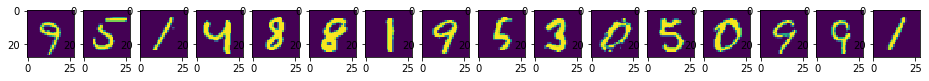

In [20]:
import random 
import boto3
import matplotlib.pyplot as plt
import numpy as np
import gzip
import json

%matplotlib inline

# Donwload MNIST test set from a public bucket
with open('code/config.json', 'rb') as f:
    CONFIG = json.load(f)

fname = 't10k-images-idx3-ubyte.gz'
bucket = CONFIG['public_bucket']
key = 'datasets/image/MNIST/' + fname
if not os.path.exists(fname):
    s3.download_file(bucket, key, fname)

# parse to numpy
with gzip.open(fname, 'rb') as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)


# randomly sample 16 images to inspect
mask = random.sample(range(images.shape[0]), 16)
samples = images[mask]

# plot the images 
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])
    

First, let us use the model to infer the samples one-by-one. This is the typical use case
for an online application.

In [21]:
# convert to float and normalize normalize the input 

def normalize(x, axis):
    eps = np.finfo(float).eps
    mean = np.mean(x, axis=axis, keepdims=True)
    # avoid division by zero
    std = np.std(x, axis=axis, keepdims=True) + eps
    return (x - mean) / std


samples = normalize(samples.astype(np.float32), axis=(1, 2)) # mean 0; std 1

res = []
for img in samples:
    data = {
        "inputs": img.flatten().tolist()
    }
    res.append(predictor.predict(data)[0])

In [22]:
print("Predictions: ", *map(int, res))

Predictions:  9 5 1 4 8 8 1 9 5 3 0 5 0 9 9 1


Since in `transform_fn`, the parsed numpy array could have take on any value for its batch
dimension, we can send the entire `samples` at once and let the model do a batch inference.

In [23]:
data = {
    "inputs": samples.tolist()
}
res = predictor.predict(data)

In [24]:
print("Predictions: ", *map(int, res))

Predictions:  9 5 1 4 8 8 1 9 5 3 0 5 0 9 9 1


## Test and debug the entry point before deployment

When deploying a model to a SageMaker endpoint, it is a good practice to test the entry 
point. The following snippet shows you how you can test and debug the `model_fn` and 
`transform_fn` you implemented in the entry point for the inference image.  

In [ ]:
!pygmentize code/test_inference.py

The `test` function simulates how the inference container works. It pulls the model
artifact loads the model into 
memory by calling `model_fn` and parse it with `model_dir`. When it receives a request, 
it calls `transform_fn` and parse it with the loaded model, 
the payload of the request, request content type and response content type. 

Implementing such a test function helps you debugging the entry point before put it into
the production. If `test` runs correctly, then you can be certain that if the incoming
data and its content type are what they suppose to be, then the endpoint point is going
to work as expected. 

## (Optional) Clean up 

If you do not plan to use the endpoint, you should delete it to free up some computation 
resource. If you use local, you will need to manually delete the docker container bounded
at port 8080 (the port that listens to the incoming request).


In [ ]:
import os

if not local_mode:
    predictor.delete_endpoint()
else:
    os.system("docker container ls | grep 8080 | awk '{print $1}' | xargs docker container rm -f")